In [119]:
import argparse
import logging
import os

import numpy as np
import torch
from torch.autograd import Variable
import utils

import torch.nn as nn
import time

import sklearn
from sklearn.metrics import accuracy_score, hamming_loss, precision_score, recall_score, f1_score

from  scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set all the relavant paths 

In [85]:
#specify the directories
code_dir = 'C:\\Users\\rsbandhu\\Documents\\MUSTBACKUP\\Details\\Computers\\DeepLearning_Stanford_CS230\\CS230_Protein_Atlas_Classification\\Code'
model_dir ='C:\\Users\\rsbandhu\\Documents\\MUSTBACKUP\\Details\\Computers\\DeepLearning_Stanford_CS230\\CS230_Protein_Atlas_Classification\\Code\\models\\Densenet169'
log_dir ='C:\\Users\\rsbandhu\\Documents\\MUSTBACKUP\\Details\\Computers\\DeepLearning_Stanford_CS230\\CS230_Protein_Atlas_Classification\\Code\\Experiments\\expt29'

#Set the working directory
os.chdir(code_dir)
cur_dir = os.getcwd()
cur_dir

import models.Densenet169.net as net
from models import data_loader

#Specify the pretrained weights and full file path
pretrained_wts_file = 'train_DN73_3ch_RGB_nodataaug_Adam__epoch_49____lr_0.0001__.pth.tar'
pretrained_wts = os.path.join(log_dir, pretrained_wts_file)

### Load pretrained model, calculate logits output of each image and find the best threshold for each class based on the valiadtion dataset

In [7]:
"""
Evaluate the model on the test set.
"""
#Specify path to the params file with hyperparameters
json_path = os.path.join(model_dir, 'params.json')
assert os.path.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = utils.Params(json_path)

threshold = torch.tensor(params.threshold, dtype = torch.float32)

# use GPU if available
cuda_present = torch.cuda.is_available() #Boolean

# Define the model and load pretrained weights
#model = net.myDensenet161(params.class_count)
#model = torch.load(pretrained_wts) # Use this for loading Amita's weights file

# Define the model and load pretrained weights
model = net.mydensenet_64_32_3(model_dir, params.class_count, drop_rate=0)
checkpoint = torch.load(pretrained_wts)
model.load_state_dict(checkpoint['state_dict'])

if cuda_present:
    model = model.cuda()

# Start the val set dataloader 
dataloader = data_loader.Dataloader(params)
val_image_dict = dataloader.load_data("val", params)
val_labels_dict = dataloader.load_labels("val", params)
val_img_count = len(val_image_dict)
val_data_generator = dataloader.data_iterator(params, "val", val_image_dict, val_labels_dict)

#Evaluate all samples in val set and optimize threshold for each class
(epoch_metrics, y_pred, y_true)  = evaluate(model, loss_fn, val_data_generator, params, val_img_count, threshold, cuda_present)
(best_threshold, best_F1) = find_optimum_threshold(y_pred, y_true, threshold, 28)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


C:\Users\rsbandhu\Documents\MUSTBACKUP\Details\Computers\DeepLearning_Stanford_CS230\CS230_Protein_Atlas_Classification\Code\models\Densenet169\densenet.py:238: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


done loading weights
train data path =  C:\Users\rsbandhu\Documents\MUSTBACKUP\Details\Computers\DeepLearning_Stanford_CS230\Project\all\train_224_new
Val data path =  C:\Users\rsbandhu\Documents\MUSTBACKUP\Details\Computers\DeepLearning_Stanford_CS230\Project\all\dev_224_new
val
datatype is val, path =  C:\Users\rsbandhu\Documents\MUSTBACKUP\Details\Computers\DeepLearning_Stanford_CS230\Project\all\dev_224_new
6304 1576
image id count =  1576


### Go through the validation images in random order and find an image that is predicted correctly on all classes

In [242]:
prediction = False
image_dir = params.test_data_path
#Shuffle the val set image id list
img_list = list(val_image_dict)
t0 = int(time.time())
np.random.seed(t0)
np.random.shuffle(img_list)
#while not prediction:
for imgid_random in img_list:
    #imgid_random = dataloader.get_random_image_id('val', params)
    
    image_data = dataloader.load_single_image('val', params, imgid_random) #this is already 4-d tensor
    if cuda_present:
        image_data = image_data.cuda(non_blocking=True)
    image_label = val_labels_dict[imgid_random]
    image_data.size()

    # set model to evaluation mode
    model.eval()
    #move model to GPU if present
    if cuda_present:
        model = model.cuda()
    #calculate features from conv layers
    with torch.no_grad():
        logits_out = model(image_data).cpu().numpy()

    #Predict 0/1 for each class based on best threshold
    y_pred = ((logits_out > best_threshold).int()*1).numpy()
    
    #calculate the difference from ground truth
    pred_diff = np.sum(np.abs(image_label -y_pred))
    if (pred_diff ==0): 
        break
print(imgid_random)
tgt_labels = list((image_label == 1).nonzero()) # find the labels that are missed, true =1, pred = 0
print("Ground truth = ", image_label)
print("predicted labels = ", y_pred)
print(tgt_labels)

9d25ecec-bb9a-11e8-b2b9-ac1f6b6435d0
Ground truth =  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0.]
predicted labels =  [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]
[array([ 0, 25], dtype=int64)]


In [256]:
val_labels_dict[imgid_random]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [87]:
#read all image channels and return the data for plotting
def read_img_channels(img_id, image_path):
    
    img_g = img_id +'_green.png'
    img_b = img_id +'_blue.png'
    img_r = img_id +'_red.png'
    img_y = img_id +'_yellow.png'
   
    b_image = mpimg.imread(os.path.join(image_path, img_b))
    g_image = mpimg.imread(os.path.join(image_path, img_g))
    r_image = mpimg.imread(os.path.join(image_path, img_r))
    y_image = mpimg.imread(os.path.join(image_path, img_y))
    
    return (b_image, g_image, r_image, y_image)

### Generate the CAM output scaled to the input image size

In [250]:
class_wts = model.classifier.weight[tgt_class,:].detach().cpu()
wts = class_wts.unsqueeze(0)
wts.size()

torch.Size([1, 768])

In [257]:
#Generate output of the last conv layer
conv_out = model.features(image_data).cpu()

#Get the features through relu before GAP layer
features_out = torch.nn.functional.relu(conv_out, inplace=True).detach()

#reshape features
m, k, h, w = features_out.size()
features = features_out.squeeze().reshape(k, -1)

#get the weights for the target class
tgt_class = tgt_labels[0][1]
class_wts = model.classifier.weight[tgt_class,:].detach().cpu()
wts = class_wts.unsqueeze(0)
#wts = class_wts
print(features.size(), wts.size())
#multiply the conv feature with the classifier weights for the target class
features_wts = torch.mm(wts,features)
cam_features = features_wts.squeeze().reshape(h,w)
#cam_features.detach()

#Project to input image size
cam_features_224_224 = ndimage.zoom(cam_features,(16,16), order =2)

torch.Size([768, 196]) torch.Size([1, 768])


### Plot all 4 channels with the CAM overlaid on each image

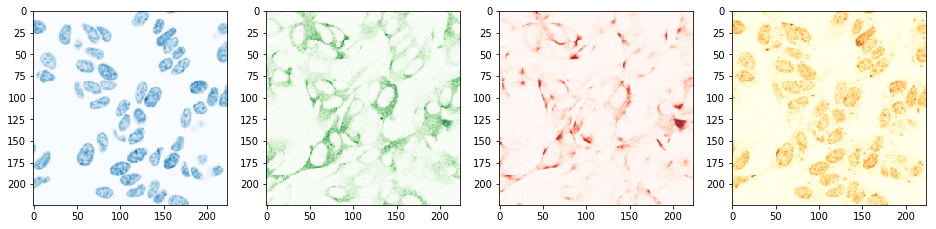

"\nimages = read_img_channels(imgid_random, image_dir)\ncolormaps = ['Blues', 'Greens', 'Reds', 'YlOrBr']\n\n#Plot the CAM and the input image\nfig, ax = plt.subplots(1,1)\n\nax.imshow(b_image, alpha = 0.1, cmap= colormaps[0])\nax.imshow(cam_features_224_224)\nax.imshow(r_image, alpha = 0.5, cmap= colormaps[2])\nfig.set_figheight(12)\nfig.set_figwidth(12)\nplt.show()\n"

In [253]:
images = read_img_channels(imgid_random, image_dir)
colormaps = ['Blues', 'Greens', 'Reds', 'YlOrBr']

fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 1
for i in range(1, columns*rows +1):
    #img = np.random.randint(10, size=(8,8))
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1],alpha = 0.8, cmap= colormaps[i-1], )
    #cam = plt.imshow(cam_features_224_224, alpha= 0.2, cmap='jet')
    #plt.colorbar(cam, orientation='horizontal')
plt.show()

'''
images = read_img_channels(imgid_random, image_dir)
colormaps = ['Blues', 'Greens', 'Reds', 'YlOrBr']

#Plot the CAM and the input image
fig, ax = plt.subplots(1,1)

ax.imshow(b_image, alpha = 0.1, cmap= colormaps[0])
ax.imshow(cam_features_224_224)
ax.imshow(r_image, alpha = 0.5, cmap= colormaps[2])
fig.set_figheight(12)
fig.set_figwidth(12)
plt.show()
'''

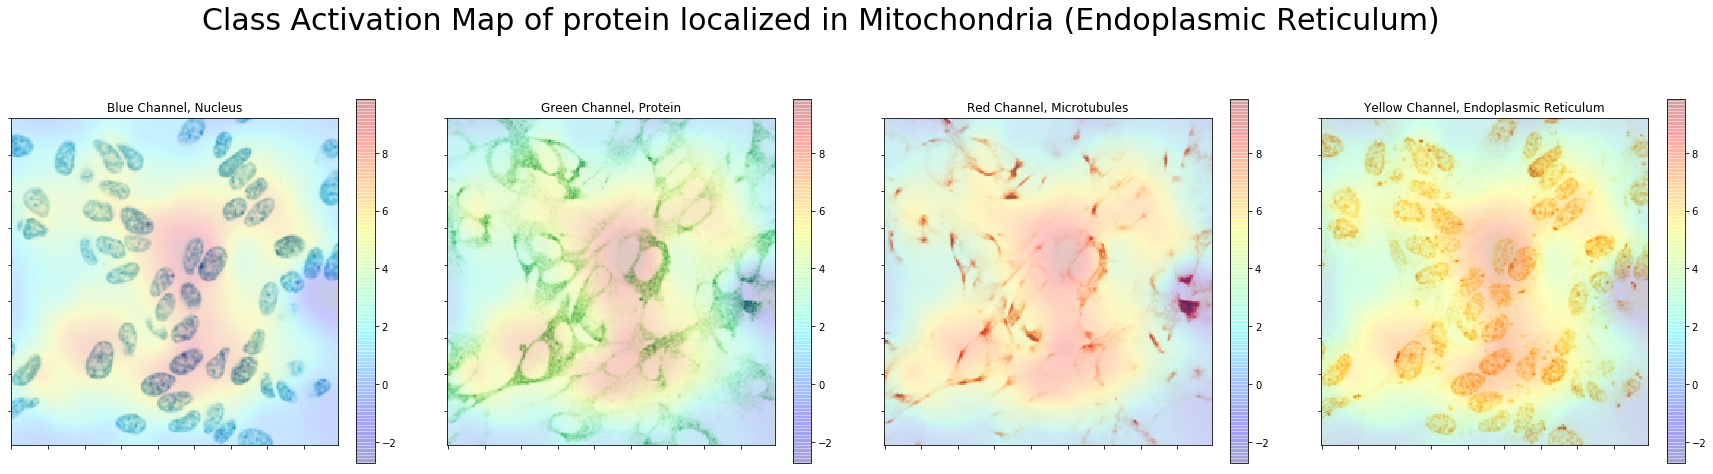

In [258]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(30, 8), ncols=4)

fig.suptitle("Class Activation Map of protein localized in Mitochondria (Endoplasmic Reticulum)", fontsize=30)

ax1.imshow(images[0],alpha = 0.8, cmap= colormaps[0], )
cam = ax1.imshow(cam_features_224_224, alpha= 0.2, cmap='jet')
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.set_title('Blue Channel, Nucleus')
fig.colorbar(cam, ax=ax1, fraction=0.05)

ax2.imshow(images[1],alpha = 0.8, cmap= colormaps[1], )
cam = ax2.imshow(cam_features_224_224, alpha= 0.2, cmap='jet')
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_title('Green Channel, Protein')
fig.colorbar(cam, ax=ax2, fraction=0.05)

ax3.imshow(images[2],alpha = 0.8, cmap= colormaps[2], )
cam = ax3.imshow(cam_features_224_224, alpha= 0.2, cmap='jet')
ax3.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_title('Red Channel, Microtubules')
fig.colorbar(cam, ax=ax3, fraction=0.05)

ax4.imshow(images[3],alpha = 0.8, cmap= colormaps[3], )
cam = ax4.imshow(cam_features_224_224, alpha= 0.2, cmap='jet')
ax4.set_yticklabels([])
ax4.set_xticklabels([])
ax4.set_title('Yellow Channel, Endoplasmic Reticulum')
fig.colorbar(cam, ax=ax4, fraction=0.05)
fig.savefig('foo.png')

In [21]:
mislabel_count =0
correct_count = 0
#Loop over all samples
for j in range(sample_count):
    diff = y_pred_bin[j,:] -(y_true[j,:]).int() #calculate the difference between pred and true labels
    labels_missed = (diff == -1).nonzero() # find the labels that are missed, true =1, pred = 0
    labels_extra = (diff == 1).nonzero() #find the labels that not present but predicted, true =0, pred = 1
    diff_sum = diff.sum()
    abs_diff_sum = torch.abs(diff).sum() #indicates how labels were wrong present or absent included
    
    # for every sample that has at least one mis classification
    if(abs_diff_sum != 0):
        #print(j, "  ***  ", (diff != 0).nonzero()[:,0], " ** true labels -->  ", (((y_true[j,:]).int()) ==1).nonzero()[:,0] )
        #print(j, "  ***  ", labels_missed, "  ****  ", labels_extra, labels_missed.size())
        # if all labels that are present in true have also been predicted, count them
        if ( labels_missed.sum() ==0):
            #print("no misses")
            mislabel_count += 1
    else:
        correct_count += 1
print(correct_count, mislabel_count)

370 493


## Helper functions for evaluation and finding best threshold

In [2]:
def evaluate(model, loss_fn, dataloader, params, img_count, threshold, cuda_present):
    """Evaluate the model on `num_steps` batches.

    Args:
        model: (torch.nn.Module) the neural network
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches data
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
        num_steps: (int) number of batches to train on, each of size params.batch_size
    """

    # set model to evaluation mode
    model.eval()

    # summary for current eval loop
    epoch_metric_summ = []
    loss_avg = utils.RunningAverage()
    loss_class_wts = torch.tensor(params.wts, dtype=torch.float32)

    #threshold = params.threshold #threshold value above which a class is considered present
    threshold = threshold  #used for parametric threshold

    y_pred = torch.zeros(img_count, params.class_count, dtype=torch.float32)
    y_true = torch.zeros(img_count, params.class_count)
    
    if cuda_present:
        loss_class_wts = loss_class_wts.cuda()
        #threshold = threshold.cuda()
    k= 0
    
    # compute metrics over the dataset
    with torch.no_grad():
        for i, (data_batch, labels_batch) in enumerate(dataloader):

            batch_size = labels_batch.size()[0] 
            y_true[k:k+ batch_size, :] = labels_batch #build entire array of predicted labels
        
            batchlabel = labels_batch

            # move to GPU if available
            if cuda_present:
                data_batch, labels_batch = data_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)
            # fetch the next evaluation batch
            data_batch, labels_batch = Variable(data_batch), Variable(labels_batch)
        
            # compute model output and loss
            prim_out = model(data_batch)

            #Compute primary, Aux and total weighted loss
            #loss_prim =loss_fn(prim_out, labels_batch,loss_class_wts)
            #loss = loss_prim
        
            #send the primary output after thresholding for metrics calc
            #yp = ((prim_out > threshold).int()*1).cpu()
            prim_out = prim_out.cpu()
            y_pred[k:k+ batch_size, :] = prim_out #build entire array of predicted labels
            k += batch_size
        
            summary_batch = metrics(prim_out, batchlabel, threshold)
            #summary_batch['loss'] = loss.item()
            epoch_metric_summ.append(summary_batch)

            #print(summary_batch)
            #loss_avg.update(loss.item())
    # compute epoch mean of all metrics in summary
    #metrics_mean = {metric:np.mean([x[metric] for x in epoch_metric_summ]) for metric in epoch_metric_summ[0]}
    #metrics_string = " ; ".join("{}: {:06.4f}".format(k, v) for k, v in metrics_mean.items())
    #logging.info("Batch: {} : - Dev set average metrics: ".format(i) + metrics_string)
    
    #Calculate the metrics of the entire dev dataset
    epoch_metrics = metrics(y_pred, y_true, threshold)
    #epoch_metrics['loss'] = loss_avg()

    train_metrics_string = " ; ".join("{}: {:06.4f}".format(k, v) for k, v in epoch_metrics.items())
    logging.info("Batch: {} : - metrics for Entire Dev dataset: ".format(i) + train_metrics_string)
    
    return (epoch_metrics, y_pred, y_true)

In [3]:
def find_optimum_threshold(y_pred, y_true, threshold, num_class):
    '''
    Finds the optimum threshbold value of each class
    Argss:
    y_pred: predicted logits value of each class
    y_true: 0/1 labels for each class
    threshold: prbably not needed
    num_class: number of classes
    Output:
    Array of best threshold value and best F1-score
    '''
    best_prec = torch.zeros(num_class)
    best_recall = torch.zeros(num_class)
    best_F1 = torch.zeros(num_class)
    best_threshold = torch.zeros(num_class)
    threshold = -15.0*torch.ones(num_class)
    t0 = time.time()
    for j in range(200):
        threshold += 0.1
        y_pred_bin = (y_pred > threshold).int()*1
        
        #macro_class_score = metrics_class(y_pred, y_true, threshold)
        #print(j, macro_class_score['precision'][0], macro_class_score['recall'][0], macro_class_score['F1_score'][0], "  threshold = ", threshold[0])
        for k in range(num_class): # loop over all class
            class_score = f1_score(y_pred_bin[:,k], y_true[:,k])
            if (class_score > best_F1[k]):
            #if macro_class_score['F1_score'][k] > best_F1[k]:
                #print(k, best_F1[k], macro_class_score['F1_score'][k], "  threshold = ", threshold[k])
                best_F1[k] = class_score
                best_threshold[k] = threshold[k]
                #print(" Class : ", k , " : best F1 score for class ", best_F1[k], " : threshold = ", threshold[k])
    t1 = time.time()
    print(t1-t0)
    for j in range(len(threshold)):
        print(j, best_threshold[j], best_F1[j])
    return (best_threshold, best_F1)

In [4]:
def metrics(outputs, labels, threshold):
    """
    Compute the accuracy, given the outputs and labels for all tokens. 
    Args:
        outputs: (torch tensor) dimension batch_size* Class Size (1/0 value for each entry)
        labels: (torch tensor) dimension batch_size* Class Size (1/0 value for each entry)
    Returns: Dictionary of accuracy, Hamming Loss, precision, Recall and F1_score macro 
    """

    #convert the torch tensors to numpy
    y_pred = outputs.numpy()
    y_true = labels.numpy()
    
    #Predict 0/1 for each class based on threshold
    y_pred = (outputs > threshold).int()*1
    #y_pred[y_pred <= threshold] = 0
    
    #Calculate various metrics, for multilabel, multiclass problem
    accuracy = accuracy_score(y_true, y_pred)
    Hloss = hamming_loss(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average = 'macro')
    recall = recall_score(y_true, y_pred, average = 'macro')
    F1_score = f1_score(y_true, y_pred, average = 'macro')
    
    macro_score = {'accuracy': accuracy, 'Hloss': Hloss, 'precision': precision, 'recall':recall, 'F1_score':F1_score }
    
    # compare outputs with labels and divide by number of tokens (excluding PADding tokens)
    return macro_score

In [5]:
def metrics_class(outputs, labels, threshold):
    """
    Compute the accuracy, given the outputs and labels for all tokens. 
    Args:
        outputs: (torch tensor) dimension batch_size* Class Size (1/0 value for each entry)
        labels: (torch tensor) dimension batch_size* Class Size (1/0 value for each entry)
    Returns: Dictionary of accuracy, Hamming Loss, precision, Recall and F1_score macro 
    """

    #convert the torch tensors to numpy
    y_pred = outputs.numpy()
    y_true = labels.numpy()

    y_pred = (outputs > threshold).int()*1
    #Predict 0/1 for each class based on threshold
    #y_pred[y_pred > threshold] = 1
    #y_pred[y_pred <= threshold] = 0
    
    #print(y_pred.size, y_true.size)
    #Calculate various metrics, for multilabel, multiclass problem
    accuracy = accuracy_score(y_true, y_pred)
    samples_miss = np.where(np.not_equal(y_pred, y_true))
    class_miss_freq = dict([item, list(samples_miss[1]).count(item)] for item in samples_miss[1])
    #Hloss = hamming_loss(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average = None)
    recall = recall_score(y_true, y_pred, average = None)
    F1_score = f1_score(y_true, y_pred, average = None)
    
    macro_class_score = {'accuracy' : accuracy, 'precision': precision, 'recall':recall, 'F1_score':F1_score, 'class_miss_freq': class_miss_freq }
    
    #print('precision')
    #print(precision)
    #print('recall')
    #print(recall)
    # compare outputs with labels and divide by number of tokens (excluding PADding tokens)
    return macro_class_score